In [1]:
import os
import torch
from torch import nn
from prototype2 import wide_resnet
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
config = {
    "batch_size": 64,
    "dataset": "food101",
    "depth": 16,
    "epochs": 100,
    "image_size": 128,
    "lr": 0.1,
    "momentum": 0.9,
    "weight_decay": 0.0005,
    "width": 8
}

state_path = "state/best_model"
model = wide_resnet.Model(config["depth"], config["width"], num_classes=101)
model = model.to(device=DEVICE, memory_format=torch.channels_last)
model.load_state_dict(torch.load(state_path, map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [4]:
print(model)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (dropout): Dropout(p=0.4, inplace=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (downsample): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): BasicBlock(
      (bn1): 

In [5]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

# 

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 13


In [6]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 3, 7, 7])
CONV: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 64, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])
CONV: Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 128, 3, 3])
CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 256, 3, 3])
CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([2

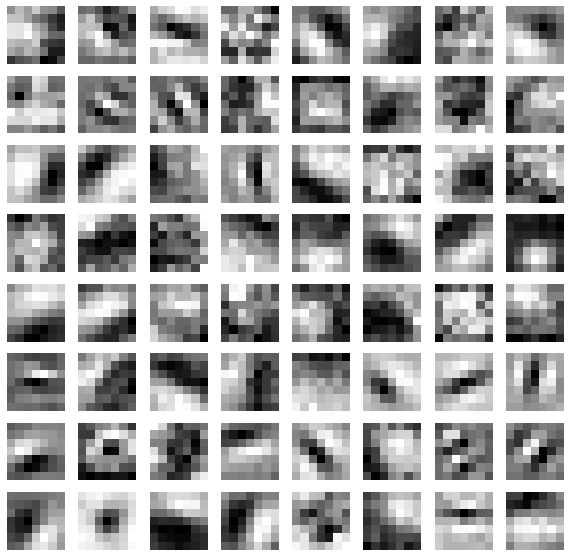

In [7]:
# visualize the first conv layer filters
plt.figure(figsize=(10, 10))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    # plt.savefig('../outputs/filter.png')
plt.show()

In [35]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Resize, CenterCrop, Normalize
TEST_DIR = "data/images/test"

transform = Compose([
    Resize((config["image_size"], config["image_size"])),
    ToTensor(),
    Normalize((0.486, 0.456, 0.406),  ## Change normalization???
                (0.229, 0.224, 0.225)),  ## Change normalization???
])
test_data = datasets.ImageFolder(root=TEST_DIR, transform=transform)
test_data_loader = DataLoader(test_data, batch_size=config["batch_size"],
                                shuffle=True, pin_memory=True, num_workers=os.cpu_count())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([3, 128, 128])


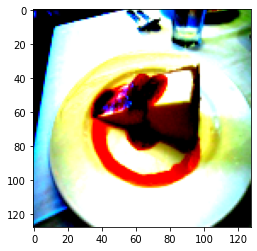

In [53]:
from PIL import Image
from torch.autograd import Variable
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = transform(image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image  #assumes that you're using GPU

image = image_loader("data/images/test/cheesecake/102854.jpg")

print(image[0].shape)
img_numpy = image.detach().numpy()
plt.imshow(image[0].permute(1,2,0))


In [56]:
# pass the image through all the layers
results = [conv_layers[0](img4d)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [57]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"./outputs/layer_{num_layer}.png")
    # plt.show()
    plt.close()

torch.Size([64, 64, 64])
Saving layer 0 feature maps...
torch.Size([128, 64, 64])
Saving layer 1 feature maps...
torch.Size([128, 64, 64])
Saving layer 2 feature maps...
torch.Size([128, 64, 64])
Saving layer 3 feature maps...
torch.Size([128, 64, 64])
Saving layer 4 feature maps...
torch.Size([256, 32, 32])
Saving layer 5 feature maps...
torch.Size([256, 32, 32])
Saving layer 6 feature maps...
torch.Size([256, 32, 32])
Saving layer 7 feature maps...
torch.Size([256, 32, 32])
Saving layer 8 feature maps...
torch.Size([512, 16, 16])
Saving layer 9 feature maps...
torch.Size([512, 16, 16])
Saving layer 10 feature maps...
torch.Size([512, 16, 16])
Saving layer 11 feature maps...
torch.Size([512, 16, 16])
Saving layer 12 feature maps...
